## Load Packages

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ColorConverter, ListedColormap
import seaborn as sns
import calendar
import datetime
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer

import plotly.offline as py
py.init_notebook_mode(connected=False)
import plotly.graph_objs as go
import plotly_express as px
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

from textblob import TextBlob

import re
import regex

import emoji

from collections import Counter

from wordcloud import WordCloud

import PIL
from PIL import Image

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from pattern.en import sentiment

import squarify
from bokeh.palettes import viridis, inferno, plasma

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\patri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Function Definitions

In [2]:
# Define function to clean text
def preprocess(ReviewText):

    ReviewText = ReviewText.str.replace("(<br/>)", "")

    ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')

    ReviewText = ReviewText.str.replace('(&amp)', '')

    ReviewText = ReviewText.str.replace('(&gt)', '')

    ReviewText = ReviewText.str.replace('(&lt)', '')

    ReviewText = ReviewText.str.replace('(\xa0)', ' ')

    return ReviewText

In [3]:
# Function to create a calendar plot of activity (posting discussions and commenting)
def calendar_plot(data, year=None, how='count', column = 'content', savefig=False, dpi=100):
    """ Adjusted calendar plot from https://pythonhosted.org/calmap/
    
    To do:
    * year set to None and find the minimum year
    * Choose column instead of using index
    * Set date as index
    
    Parameters:
    -----------
    year : boolean, default None
    how : string, default 'count'
        Which methods to group by the values. 
        Note, it is always by day due to the
        nature of a calendar plot. 
    column : string, default 'User'
        The column over which you either count or sum the values
        For example, count activity in a single day.
    savefig : boolean, default False
        Whether or not to save the figure instead of showing.
    dpi : int, default 100
        Resolution of the figure you want to save.
    
    
    """
    
    # Get minimum year if not given
    if year == None:
        year = data.postDate.min().year
    
    # Prepare data
    data = data.set_index('postDate').loc[:, column]
    
    # Resample data
    if how == 'sum':
        daily = data.resample('D').sum()
    elif how == 'count':
        daily = data.resample('D').count()
    
    vmin = daily.min()
    vmax = daily.max()

    # Fill in missing dates
    daily = daily.reindex(pd.date_range(start=str(year), end=str(year + 1), 
                                        freq='D')[:-1])

    # Put into dataframe
    # Fill is needed to created the initial raster
    daily = pd.DataFrame({'data': daily,
                           'fill': 1,
                           'day': daily.index.dayofweek,
                           'week': daily.index.week})

    # Correctly choose week and day
    daily.loc[(daily.index.month == 1) & (daily.week > 50), 'week'] = 0
    daily.loc[(daily.index.month == 12) & (daily.week < 10), 'week'] \
        = daily.week.max() + 1

    # Create data to be plotted
    plot_data = daily.pivot('day', 'week', 'data').values[::-1]
    plot_data = np.ma.masked_where(np.isnan(plot_data), plot_data)

    # Create data for the background (all days)
    fill_data = daily.pivot('day', 'week', 'fill').values[::-1]
    fill_data = np.ma.masked_where(np.isnan(fill_data), fill_data)

    # Set plotting values
    cmap='OrRd'
    linewidth=1
    linecolor = 'white'
    fillcolor='whitesmoke'

    # Draw heatmap for all days of the year with fill color.
    fig = plt.figure(figsize=(20, 10))
    ax = plt.gca()
    ax.pcolormesh(fill_data, vmin=0, vmax=1, cmap=ListedColormap([fillcolor]))
    ax.pcolormesh(plot_data, vmin=vmin, vmax=vmax, cmap=cmap, 
                  linewidth=linewidth, edgecolors=linecolor)

    # Limit heatmap to our data.
    ax.set(xlim=(0, plot_data.shape[1]), ylim=(0, plot_data.shape[0]))

    # # Square cells.
    ax.set_aspect('equal')

    # plt.axis('off')

    # Remove spines and ticks.
    for side in ('top', 'right', 'left', 'bottom'):
        ax.spines[side].set_visible(False)
    ax.xaxis.set_tick_params(which='both', length=0)
    ax.yaxis.set_tick_params(which='both', length=0)

    # Get ticks and labels for days and months
    daylabels=calendar.day_abbr[:]
    dayticks = range(len(daylabels))

    monthlabels=calendar.month_abbr[1:]
    monthticks = range(len(monthlabels))

    # Create label and ticks for x axis
    font = {'fontsize':20}
    ax.set_xlabel('')
    ax.set_xticks([daily.loc[datetime.date(year, i + 1, 15),:].week
                   for i in monthticks])
    ax.set_xticklabels([monthlabels[i] for i in monthticks], ha='center', **font)

    # Create label and ticks for y axis
    font = {'fontsize':15}
    ax.set_ylabel('')
    ax.yaxis.set_ticks_position('right')
    ax.set_yticks([6 - i + 0.5 for i in dayticks])
    ax.set_yticklabels([daylabels[i] for i in dayticks], rotation='horizontal',
                       va='center', **font)
    
#     ax.set_xlim(0, 54)

    ax.set_ylabel(str(year), fontsize=20,color='#DCDCDC',fontweight='bold', ha='center'); 
    if savefig:
        fig.savefig('ASHRAE - Activity Heat Map.jpg', format="jpg", dpi=dpi)
    plt.show()

In [4]:
# Taken from SOAN package (https://github.com/MaartenGr/soan/blob/master/whatsapp/sentiment.py with modifications
def plot_sentiment(df, savefig=False):
    """ Plots the weekly average sentiment over 
    time per user
    
    Parameters:
    -----------
    df : pandas dataframe
        Dataframe of all messages per user including
        a column called 'polarity' that includes values
        ranging from -1 to 1. 
    savefig : boolean, default False
        If True it will save the figure in the 
        working directory
    """
    
    # Resample to a week by summing
    df = df.set_index('postDate')

    users = df.resample('1D').mean().reset_index()

    # Fill in missing values by taking the average of previous/next
    users['polarity']  = users['polarity'].interpolate()

    # Create figure and plot lines
    fig, ax = plt.subplots()

    ax.plot(users.postDate, users.polarity, linewidth=2)

    # Remove axis
    # ax.spines['left'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Limit graph
    plt.ylim(ymin=-1, ymax=1)
    # plt.xlim(xmin=datetime.date(2016, 8, 15))

    # Add lines instead of axis
    plt.axhline(-1, color='black', xmax=1, lw=7)
    # plt.axvline(datetime.date(2016, 8, 15), color='black', lw=7)

    # Setting emojis as y-axis
    font = {'fontname':'DejaVu Sans', 'fontsize':22}
    ax.set_yticks([-1, 0, 1])
    ax.set_yticklabels(['\U0001f62D','\U0001f610','\U0001f604'], **font)

    # Set ticks to display month and year
    monthyearFmt = mdates.DateFormatter('%B %Y')
    ax.xaxis.set_major_formatter(monthyearFmt)
    plt.xticks(rotation=40)

    # Create legend    
    font = {'fontsize':24}
    ax.set_title('Positivity of Discussion Posts and Comments', **font)

    # Set size of graph
    fig.set_size_inches(13, 5)
    fig.tight_layout()
    
    if savefig:
        fig.savefig('ASHRAE - Sentiment over time.jpg', dpi=300)

In [5]:
def extract_emojis(str):
  return ''.join(c for c in str if c in emoji.UNICODE_EMOJI)

def prepare_data(df):
    """ Prepares the data by extracting and 
    counting emojis per row (per message).
    
    New columns:
    * Emoji - List of emojis that are in the message
    * Emoji_count - Number of emojis used in a message
    * Different_Emojis - Number of unique emojis used in a message
    
    Parameters:
    -----------
    df : pandas dataframe
        Dataframe containing raw messages of whatsapp users
    Returns:
    --------
    df : pandas dataframe
        Dataframe containing raw messages of whatsapp users with
        the added columns containing information about emoji use
    
    """
    
    # Extract unicode emojis per message and count them
    df['Emoji'] = df.apply(lambda row: extract_emojis(str(row.content)), 
                                       axis = 1)
    df['Emoji_Count'] = df.apply(lambda row: len(regex.findall(r'\p{So}\p{Sk}*', 
                                                                           row.Emoji)), axis = 1)
    
    # Find non-unicode smileys
    eyes, noses, mouths = r":;8BX=", r"-~'^", r")(/\|DPp"
    pattern = "[%s][%s]?[%s]" % tuple(map(re.escape, [eyes, noses, mouths]))
    df['Different_Emojis'] = df.apply(lambda row: re.findall(pattern, str(row.content)), 
                                                  axis=1)
    
    return df

def count_emojis(df, non_unicode = False):
    """ Calculates how often emojis are used between users
    
    Parameters:
    -----------
    df : pandas dataframe
        Dataframe containing raw messages of whatsapp users
    non_unicode : boolean, default False
        Whether to count the non-unicode emojis or not
        
    Returns:
    --------
    emoji_all : dictionary of Counters
        Indicating which emojis are often used by which user
    """
    
    emoji_all = {}

    # Count all "actual" emojis and not yet text smileys
    # Count all sets of emojis
    temp_user = df.Emoji[(df.Emoji_Count < 20)].value_counts().to_dict()
    emoji_all = {}

    # Go over all set of emojis
    for emojis, count in temp_user.items():
            
        # Create a list of emojis
        emojis = regex.findall(r'\p{So}\p{Sk}*', emojis)

        # Loop over individual emojis
        for emoji_value in emojis:

            # Skip empty values
            if emoji_value != '':     
                try:
                    emoji_all[emoji_value] += count
                except:
                    emoji_all[emoji_value] = count
                
    # Count non-unicode smileys
    if non_unicode:
        # Loop over
        for _, row in df[(df.Different_Emojis.str.len() > 0)].iterrows():
            for some_emoji in row.Different_Emojis:
                if len(some_emoji) > 1:
                    try:
                        emoji_all[some_emoji] += 1
                    except:
                        emoji_all[some_emoji] = 1        

    return emoji_all

In [6]:
# Taken from SOAN package (https://github.com/MaartenGr/soan/blob/master/whatsapp/wordcloud.py with modifications
def create_wordcloud(data, cmap=None, savefig=False, **kwargs):
    """ Creates a wordcloud based on a text document
    
    Parameters:
    -----------
    data : list, pandas series or dictionary
        List of words, pandas series of messages
        or dictionary that includes words with 
        frequency. If a dictionary is supplied
    cmap : str, default None
        A string that relates that a matplotlib
        color map. See:
        https://matplotlib.org/examples/color/colormaps_reference.html
    savefig : boolean, default False
        Whether or not to save the file, if True
        then it will be saved in the current
        working directory        
        
    Returns:
    --------
    PIL.Image.Image
        An image as presented in PIL (Pillow)
    """
    
    # Add mask if present
    if 'mask' in kwargs.keys():
        kwargs['mask'] = np.array(Image.open(kwargs['mask']))
    
    stop_words = stopwords.words("english")
    stop_words.extend(['https', 'youtu', '\\n', '\\u', 'http', 'don', 'didn'])        
    kwargs['stopwords'] = stop_words
    
    # Create Word Cloud
    wc = WordCloud(background_color="white", mode='RGBA', collocations = True, **kwargs)
    
    if type(data) != dict:
        text = ' '.join(data)
        wc.generate_from_text(text)
    else:
        wc.generate_from_frequencies(data)
        
    if not cmap:
        wc.recolor(color_func=color_func, random_state=kwargs['random_state'])
    else:
        wc.recolor(colormap=cmap, random_state=kwargs['random_state'])
        
    if savefig:
        wc.to_file("ASHRAE wordcloud.jpg")
    return wc.to_image()

In [7]:
# Taken from SOAN package (https://github.com/MaartenGr/soan/blob/master/whatsapp/wordcloud.py with modifications
def extract_sentiment_count(counts):
    """ Extract and return counts of negative and positive words
    Positivity is based on the Pattern package which gives
    sentiment values between -1 (negative) and 1 (positive). 
    Words with a sentiment > 0 are positive and words
    with a sentiment < 0 are negative. All others are classified
    as being neutral. 
    
    Parameters:
    -----------
    counts : pandas dataframe
        Dataframe that contains a count of how often
        a user has used a word. 
        
    Returns:
    --------
    positive, negative : dictionary
        Contains counts of positive words used and
        counts of negative words used
    """
    
    counts_dict = counts[['Word','Count']].set_index('Word').to_dict()['Count']
    counts_dict = {key: value for key, value in counts_dict.items() if value > 0}

    positive = {}
    negative = {}

    for word in counts_dict.keys():
        if sentiment(word)[0] < 0:
            negative[word] = counts_dict[word]
        if sentiment(word)[0] > 0:
            positive[word] = counts_dict[word]
            
    return positive, negative

In [8]:
def count_words(df, sentence_column = "content"):
    """ Creates a count vector in which
        the occurence of each word is count over all 
        documents. 
    Parameters:
    -----------
    df : pandas dataframe
        Dataframe of all messages
    sentence_column : string, default 'Message_Only_Text'
        Name of the column of which you want to 
        create a word count
        
    Returns:
    --------
    df : pandas dataframe
        Dataframe counts per word per user
    
    """
    # Creating a dataframe with all words
    counts = list(Counter(" ".join(list(df[sentence_column])).split(" ")).items())
    counts = [word[0] for word in counts]
    counts = pd.DataFrame(counts, columns = ['Word'])
    counts = counts.drop(0)
    
    #print(counts)

    # Adding counts of each user to the dataframe
    count_temp = list(Counter(" ".join(list(df['content'])).split(" ")).items())
    for word, count in count_temp:
        counts.loc[counts['Word'] == word, 'Count'] = count
            
    counts = counts[counts.Word.str.len() > 1]
            
    return counts

## Load Data

In [9]:
post_df = pd.read_csv('discussions.csv')
comments_df = pd.read_csv('comments.csv')

In [10]:
# Add title information to post content
post_df['content'] = post_df['content'].str.cat(post_df['title'], sep =". ", join = 'inner', na_rep = '')

In [11]:
# Modify timeformat of post data
post_df['postDate'] = pd.to_datetime(post_df['postDate'], format='%d/%m/%Y %H:%M')

# Create combined dataframe
combined_df = pd.concat([comments_df,post_df], ignore_index=True, join='inner')

In [12]:
post_df['content'] = preprocess(post_df['content'])
combined_df['content'] = preprocess(combined_df['content'])
combined_df['content'] = combined_df['content'].apply(str)

post_df['polarity'] = post_df['content'].map(lambda text: TextBlob(text).sentiment.polarity)
combined_df['polarity'] = combined_df['content'].map(lambda text: TextBlob(text).sentiment.polarity)

post_df['post_len'] = post_df['content'].astype(str).apply(len)

post_df['word_count'] = post_df['content'].apply(lambda x: len(str(x).split()))

## Exploratory Data Analysis

In [13]:
# Summary Information

# The total number of posts in this competition
print("The total number of posts related to the ASHRAE Competition:",len(post_df))

# The total number of comments in this competition
print("The total number of comments related to the ASHRAE Competition:",len(comments_df))

# The number of competitors who participated in the discussion forum (either posting or commenting)
print("The number of competitors who participated in the ASHRAE Competition discussion forums:",len(np.unique(combined_df['author'])))

The total number of posts related to the ASHRAE Competition: 293
The total number of comments related to the ASHRAE Competition: 2508
The number of competitors who participated in the ASHRAE Competition discussion forums: 713


In [14]:
# Rank discussions by upvotes
print(post_df.sort_values(by = ['votes'], ascending=False)[['title','votes']])

                                              title  votes
0                 Energy prediction - small summary    220
13                                   Year-long path    108
15   Sites, buildings identified by internet search    107
11                                Findings from EDA    104
12                                       LB probing     98
..                                              ...    ...
290                    Need 3rd decimal of LB score     -2
291                orderliness in discussion forums     -3
258                                      Strike ???     -6
277       private lb now uses 11% of the test data?     -8
262                               Not Fair at all !    -20

[293 rows x 2 columns]


In [15]:
# Plot the distribution discussion post length
fig = px.histogram(post_df['post_len'], 
             x='post_len', 
             y='post_len', 
             title='Discussion Post Length (# of Characters) Distribution', 
             nbins=25,
            color_discrete_sequence=['darkblue'])

fig.update_traces(marker_line_color='rgb(0,0,0)',marker_line_width=1.5)

fig.show()

#fig.write_image("ASHRAE - Discussion Post Length.jpg", width=1200, height=600)

## Sentiment Analysis

In [16]:
print('5 posts with the highest sentiment polarity: \n')
cl = post_df.loc[post_df.polarity > 0.4, ['content']].sample(5).values
for c in cl:
    print(c[0])

5 posts with the highest sentiment polarity: 

Just wanted to ask if its okay to be using data that is there online.  Would this not be a breach of contest rules and if the org will be providing the leaked data for us in some way.. Do we integrate the data that's available online or should we not?
How to handle this data while merging the data frames. It falls in memory error. Handling huge data
Thanks for the great kagglers' sharing. I tried many kinds of feature engineering and model ensemble methods but it seems a gap still exists between the top and mine.
EDA is EVERYTHING.
I will post my linear regression model later. The idea is from @abednadir 's great r code.. Should have realized this is an ANOMALY DETECTION PROBLEM
It seems like an inferno here…
More decimal digits would help a lot, but for the rest , I would not discuss…
Good luck everybody, may the force be with you, anyway !. Two months, Two digits decimals, 2 submissions a day...
I have a bittersweet feeling, the last wee

In [17]:
print('5 posts/comments with the highest sentiment polarity: \n')
cl = post_df.loc[post_df.polarity > 0.5 , ['content']].sample(5).values
for c in cl:
    print(c[0])

5 posts/comments with the highest sentiment polarity: 

It seems like an inferno here…
More decimal digits would help a lot, but for the rest , I would not discuss…
Good luck everybody, may the force be with you, anyway !. Two months, Two digits decimals, 2 submissions a day...
Moving along with the competition, just need to know the views which is the best way to tackle the dataset and proceed with modelling!!. is the Best way time series or regression?
Hi, everyone! So, how are you guys working with lag features? are you using it at all? I tried some with the weather and then with the building but i didn't get a good result… I'm using a LGBM model and currently my best score was without then.. Lag Features
While all of us are waiting patiently for Pvt. LB update after Christmas, I wanted to wish all of the teams and the competition organizers very happy holidays. Wishing for many more exciting competitions in 2020. 😃 😊 . Happy Holidays everyone
I have a bittersweet feeling, the last 

In [18]:
print('2 posts with the most negative polarity: \n')
cl = post_df.loc[post_df.polarity < -0.4, ['content']].sample(2).values
for c in cl:
    print(c[0])

2 posts with the most negative polarity: 

When I just faced zeroes in target variable, I just thought the meter_reader(?) went wrong. So I just thought I could predict target variable's 'zeroes' with ML. Is this a stupid idea?. How do you think predicting zeroes in target variable?
With all the data scraping this competition has gotten extremely weird.. Leaving the competition


In [19]:
# Plot the distribution of polarity of sentiments in discussion posts
fig = px.histogram(post_df['polarity'], 
             x='polarity', 
             y='polarity', 
             title='Sentiment Polarity Distribution', 
             nbins=50,
            color_discrete_sequence=['darkblue'])

fig.update_traces(marker_line_color='rgb(0,0,0)',marker_line_width=1.5)
fig.update_layout(font_size=30)

fig.show()

#fig.write_image("ASHRAE - Sentiment Polarity.pdf", width=1000, height=1000)

[Text(0, 0.5, 'count of polarity'), Text(0.5, 0, 'polarity')]

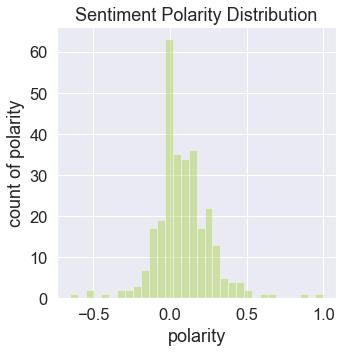

In [20]:
sns.set(font_scale = 1.5)
plt.figure(figsize=(5,5))
ax = sns.distplot(post_df['polarity'], kde=False, color= "yellowgreen")
ax.title.set_text("Sentiment Polarity Distribution")
ax.set(ylabel="count of polarity", xlabel="polarity")

In [21]:
# Remove comments with no content (e.g. picture/meme comments)
combined_df = combined_df[~combined_df['content'].isnull()]

In [22]:
# Inspect top unigrams (after removing stop words)
# Based from work of Susan Li (https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-
# visualization-for-text-data-29fb1b96fb6a).
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(combined_df['content'], 20)

df1 = pd.DataFrame(common_words, columns = ['content' , 'count'])

df1.groupby('content').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in discussions after removing stop words')

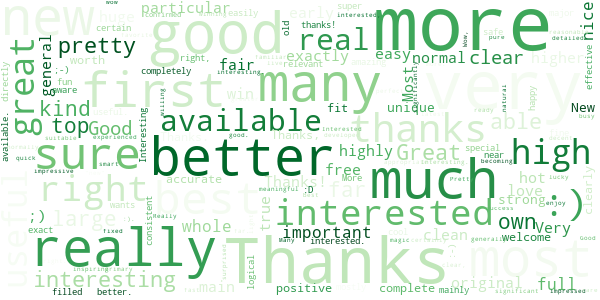

In [23]:
# As word cloud
counts = count_words(combined_df, sentence_column = "content")

positive, negative = extract_sentiment_count(counts)

create_wordcloud(data=positive, cmap='Greens', 
#                           mask='mask.jpg',      
                           random_state=42, max_words=1000,  
                           max_font_size=50, scale=1.5, 
                           normalize_plurals=False,  
                           relative_scaling=0.5)

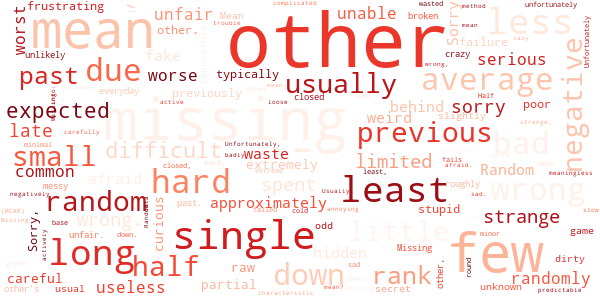

In [24]:
create_wordcloud(data=negative, cmap='Reds', 
#                           mask='mask.jpg',      
                           random_state=42, max_words=1000,  
                           max_font_size=50, scale=1.5, 
                           normalize_plurals=False,  
                           relative_scaling=0.5)

In [25]:
# Inspect top bigrams (after removing stop words)
# Based from work of Susan Li (https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-
# visualization-for-text-data-29fb1b96fb6a).
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(combined_df['content'], 20)

df2 = pd.DataFrame(common_words, columns = ['content' , 'count'])

fig = px.bar(df2, x = 'content', y = 'count',
             title='Top 20 bigrams in discussions after removing stop words', 
            color_discrete_sequence=['indianred'])

fig.update_traces(marker_line_color='rgb(0,0,0)',marker_line_width=1.5)

fig.show()

#fig.write_image("ASHRAE - Top Bigrams.jpg", width=1200, height=600)

In [26]:
# Inspect top trigrams (after removing stop words)
# Based from work of Susan Li (https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-
# visualization-for-text-data-29fb1b96fb6a).
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_trigram(combined_df['content'], 20)

df3 = pd.DataFrame(common_words, columns = ['content' , 'count'])
df3.groupby('content').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in discussions after removing stop words')

## Temporal Analysis

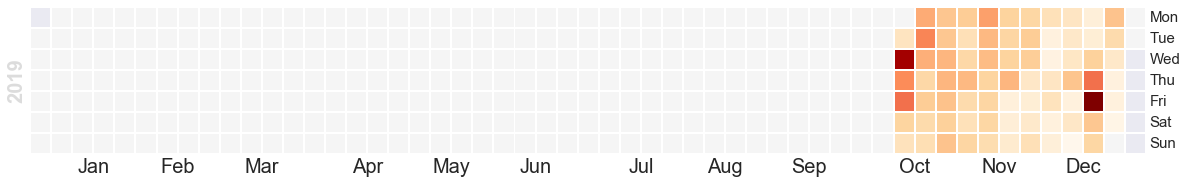

In [27]:
# Create a plot showing activity levels over the competition timeframe (in terms of posting discussions and commenting)
combined_df['postDate'] = pd.to_datetime(combined_df['postDate'], format='%Y-%m-%d %H:%M:%S')
calendar_plot(combined_df, year=None, how='count', column = 'content', savefig=True, dpi=300)

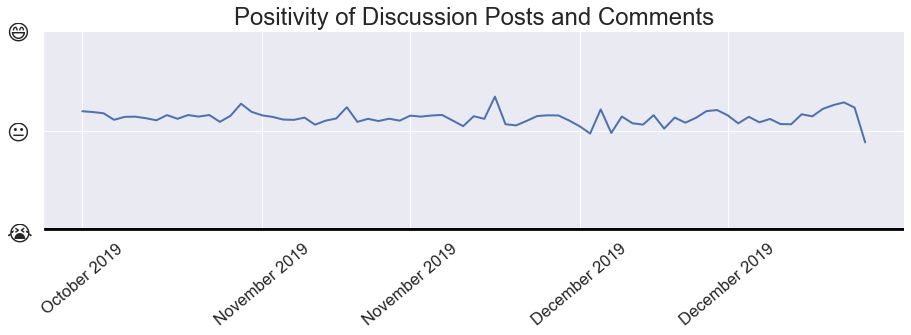

In [28]:
# Sentiment analysis over time
plot_sentiment(combined_df, savefig = True)

In [29]:
# Emoji analysis
combined_df = prepare_data(combined_df)
df4 = pd.DataFrame.from_dict(count_emojis(combined_df, non_unicode = False), orient='index', columns = ['Count'])

fig = px.bar(df4['Count'].sort_values(ascending=False), x = df4.index, y = 'Count',
             title='Histogram of Emoji Use in Kaggle ASHRAE Competition', 
            color_discrete_sequence=['indianred'])

fig.update_traces(marker_line_color='rgb(0,0,0)',marker_line_width=1.5)

fig.show()

#fig.write_image("ASHRAE - Emoji Histogram.jpg", width=1200, height=600)

### Create Treemap of Discussion Topics

In [30]:
# Create dataframe with counts of the discussion post 'tags'
topic_counts = post_df['tag'].value_counts()
topic_counts = topic_counts.to_frame()

# Assign column names
topic_counts.columns = ['Count']

print(topic_counts)

                               Count
Question                          43
Data Leak                         28
Feature Selection/Extraction      22
Other                             21
Preprocessing                     19
Modelling Strategy                18
Memory & Optimisation             17
Reference Material                16
EDA                               13
Data Quality                      13
Error Metric + Postprocessing     11
Kaggle + Technical Committee      11
Competition Feedback              11
Solution                          10
Rules and Enforcement              9
Site Locations                     8
LB Probing                         6
Cross-validation                   6
Team Formation                     6
Weather                            5


In [31]:
# Add \n to long label names
#as_list = topic_counts.index.tolist()
#idx = as_list.index('Error Metric + Postprocessing')
#as_list[idx] = 'Error Metric + \nPostprocessing'
#topic_counts.index = as_list

topic_counts.rename(index={'Error Metric + Postprocessing':'Error Metric +\nPostprocessing','Rules and Enforcement':
                          'Rules &\nEnforcement','Kaggle + Technical Committee':'Kaggle +\nTechnical Committee',
                          'Competition Feedback':'Competition\nFeedback','Memory & Optimisation':'Memory &\nOptimisation',
                          'Modelling Strategy':'Modelling \nStrategy','Reference Material':'Reference \nMaterial',
                          'Feature Selection/Extraction':'Feature \nSelection/Extraction','Team Formation':'Team \nFormation',
                          'Cross-validation':'Cross-\nValidation','Site Locations':'Site \nLocations'},inplace=True)

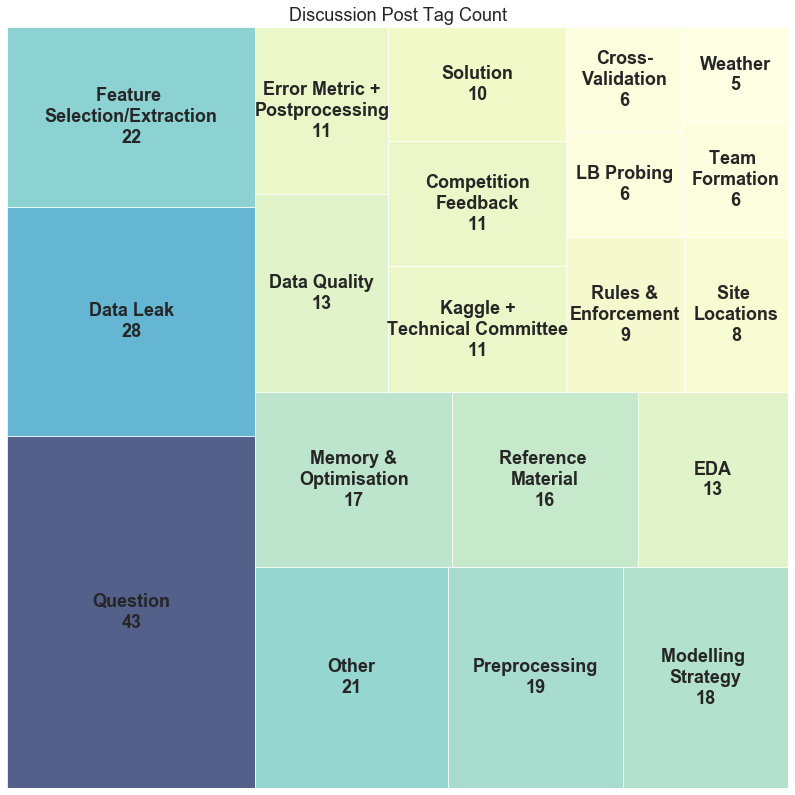

In [32]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 14)

norm = matplotlib.colors.Normalize(vmin=min(topic_counts['Count']), vmax=max(topic_counts['Count']))
colors = [matplotlib.cm.YlGnBu(norm(value)) for value in topic_counts['Count']]

squarify.plot(sizes=topic_counts['Count'],
                  label=topic_counts.index + '\n' + topic_counts['Count'].astype(str),
                  alpha=.7,
                  color = colors,
                  text_kwargs={'fontsize':18, 'weight':'bold'})
plt.axis('off')
plt.title('Discussion Post Tag Count')
plt.savefig('ASHRAE - Discussion Tag Treemap.jpg', dpi = 300)
plt.show()